In [69]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.animation as animation
import os
from models.BlendedDiffusion import BlendedDiffusion
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import itertools
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from datasets import load_dataset, DownloadManager, Image, load_from_disk, concatenate_datasets
import torch
from torch.utils.data import DataLoader
from diffusers import StableDiffusionPipeline
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None

# Load Datasets

In [3]:
# method used for adding a column called label to a huggingface dataset
def add_label(dataset_row, label):
    dataset_row['label'] = label
    return dataset_row

def resize_images(dataset_row):
    # the diffusion model generates images of size 512 x 512
    dataset_row['image'] = [image.resize((512, 512)) for image in dataset_row['image']]
    return dataset_row


Size: 14904
outer, The North Face 1996 Eco Nuptse Jacket Black, a photography of the north face black down jacket
Image Size: (512, 512)


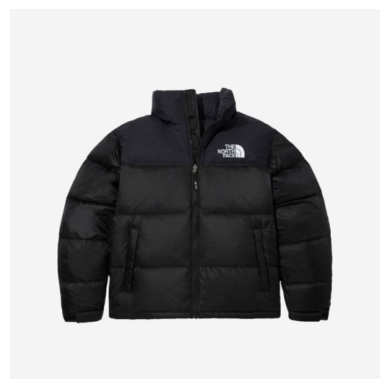

In [4]:
def get_clothes_dataset():
    dataset_path = './clothes_dataset'
    try:
        clothes_dataset = load_from_disk(dataset_path)
    except FileNotFoundError:
        clothes_dataset = load_dataset("hahminlew/kream-product-blip-captions", split="train") # only has a train split
        clothes_dataset = clothes_dataset.map(lambda row: add_label(row, 'clothes')).map(function=resize_images, batched=True, num_proc=6)
        clothes_dataset.save_to_disk(dataset_path)
    return clothes_dataset

clothes_dataset = get_clothes_dataset()
sample = clothes_dataset[0]
clothes_dataset_size = len(clothes_dataset)
print('Size:', clothes_dataset_size)
print(sample["text"])
print('Image Size:', sample['image'].size)
plt.axis('off')
plt.imshow(sample['image']) # originally, images are 525 x 525 pixels but are resized to 512 x 512

a pixel art character with square black glasses, a hotdog-shaped head and a peachy-colored body on a warm background


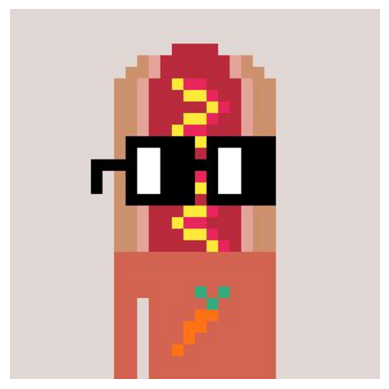

In [5]:
def get_pixelart_dataset(clothes_dataset_size):
    dataset_path = './pixelart_dataset'
    try:
        pixelart_dataset = load_from_disk(dataset_path)
    except FileNotFoundError:
        pixelart_dataset = load_dataset('m1guelpf/nouns', split='train') # only has a train split too
        pixelart_dataset = pixelart_dataset.select(range(clothes_dataset_size)).map(lambda row: add_label(row, 'pixel_art')).map(
            function=resize_images, batched=True, num_proc=6)
        pixelart_dataset.save_to_disk(dataset_path)
    return pixelart_dataset

pixelart_dataset = get_pixelart_dataset(clothes_dataset_size)
sample = pixelart_dataset[0]
print(sample["text"])
plt.axis('off')
plt.imshow(sample['image']) # originally, images are 320 x 320 pixels but are resized to 512 x 512

silhouette of structure under red sky


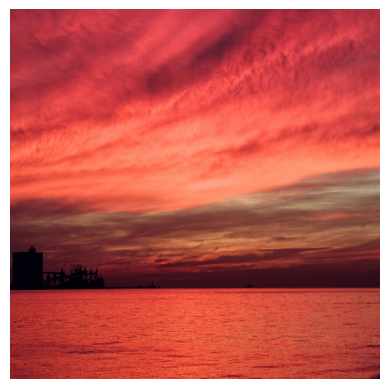

In [6]:
def get_photograph_dataset(clothes_dataset_size):
    dataset_path = './photograph_dataset'

    try:
        photograph_dataset = load_from_disk(dataset_path)
    except FileNotFoundError:
        photograph_dataset = load_dataset('1aurent/unsplash-lite-palette', split='train') # also, this dataset only has train split
        photograph_dataset = photograph_dataset.select(range(clothes_dataset_size))

        def download_image(url: str | list[str], dl_manager: DownloadManager):
            filenames = dl_manager.download(url)
            return {"image": filenames}
        
        photograph_dataset = photograph_dataset.map(
            function=download_image,
            input_columns=["url"],
            fn_kwargs={
                "dl_manager": DownloadManager(),
            },
            batched=True,
            num_proc=1,
        )
        photograph_dataset = photograph_dataset.cast_column(
            column="image",
            feature=Image(),
        ).map(function=resize_images, batched=True, num_proc=1)
        photograph_dataset = photograph_dataset.remove_columns(['url', 'palettes'])
        photograph_dataset = photograph_dataset.rename_column('ai_description', 'text').map(lambda row: add_label(row, 'photographs'))
        photograph_dataset.save_to_disk(dataset_path)
    return photograph_dataset

photo_graph_dataset = get_photograph_dataset(clothes_dataset_size)
sample = photo_graph_dataset[0]
print(sample["text"])
plt.axis('off')
plt.imshow(sample['image'])

# Generate 2 samples

In [7]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"
# init original
pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

# init blended
lora_paths = ['./model_downloads/clothes_finetuned_model', './model_downloads/pixelart_finetuned_model', 
              './model_downloads/photograph_finetuned_model']
stable_diffusion_model = BlendedDiffusion(model_id, lora_paths)

stable_diffusion_model = stable_diffusion_model.to(device, dtype=torch.float32)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
model_name = "openai/clip-vit-large-patch14"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

  0%|          | 0/50 [00:00<?, ?it/s]

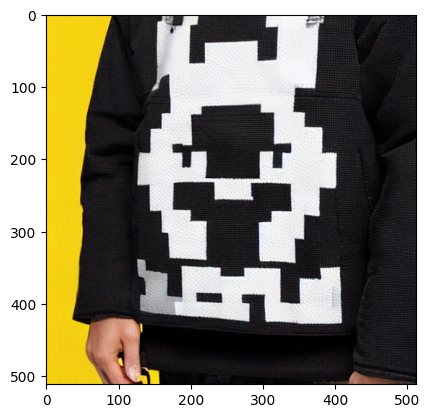

  0%|          | 0/50 [00:00<?, ?it/s]

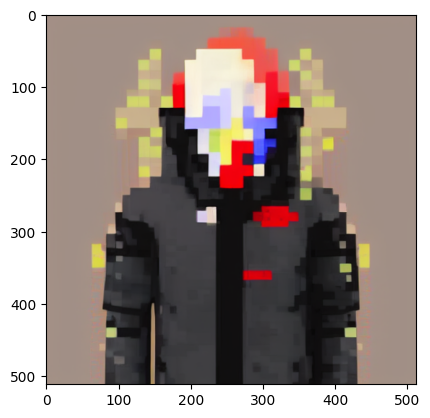

In [11]:
prompts = ['a pixelated character wearing a black north face jacket']
# generate from original
image_o = pipe(prompts)
plt.imshow(image_o.images[0])
plt.show()

# generate from blended
stable_diffusion_model.eval()
with torch.no_grad():
    image_b = stable_diffusion_model(prompts[0])
plt.imshow(image_b[0])
plt.show()

# Evaluation of 2 generated images

In [74]:
def generate_embeddings(clip_model, clip_processor, datasets, original, blended, num_instances, num_components):
    embeds = {}
    for ds in datasets:
        embeds[ds] = np.array([clip_model.get_image_features(**clip_processor(images=datasets[ds][x]['image'], 
                                    requires_grad=False, 
                                    return_tensors="pt")).detach().numpy() for x in tqdm(range(num_instances))])[:,0,:]
    
    embeds['original'] = clip_model.get_image_features(**clip_processor(images=original, 
                                    requires_grad=False, 
                                    return_tensors="pt")).detach().numpy()
    embeds['blended'] = clip_model.get_image_features(**clip_processor(images=blended, 
                                    requires_grad=False, 
                                    return_tensors="pt")).detach().numpy()
    return embeds

def generate_frames(sub_matrix, categories, num_frames, components):
    colors = itertools.cycle(["r", "b", "g"])
    multiplier = 360 / num_frames
    for frame_id in tqdm(range(num_frames)):

        fig = plt.figure(figsize=(5, 5))
        if components == 3:
            ax = fig.add_subplot(projection='3d')
        else:
            ax = fig.add_subplot()
        
        # plot all categories
        for i, c in enumerate(categories):
            x=sub_matrix[i*100:(i+1)*100, 0]
            y=sub_matrix[i*100:(i+1)*100, 1]
            if components == 3:
                z=sub_matrix[i*100:(i+1)*100, 2]
                ax.scatter(x, y, zs=z, zdir='z', color=c[1], label=c[0], alpha=0.25)
            else:
                ax.scatter(x, y, color=cat[1], label=cat[0], alpha=0.25)

        # plot original and blended
        x_s = sub_matrix[-2:, 0]
        y_s = sub_matrix[-2:, 1]

        if components == 3:
            z_s = sub_matrix[-2:, 2]
            ax.plot(x_s, y_s, z_s, '-o', color='black')
            ax.plot(x_s[-1], y_s[-1], z_s[-1], '-s', color='black')
        else:
            ax.plot(x_s, y_s, '-o', color='black')
            ax.plot(x_s[-1], y_s[-1], '-s', color='black')

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        if components == 3:
            ax.set_zlabel('z')

        ax.view_init(20, frame_id*multiplier)
        ax.legend(bbox_to_anchor=(1.1, 1))

        plt.savefig(f'./frames/frame_{frame_id:04d}.png')

def generate_gif():
    frames = [] # for storing the generated images
    fig = plt.figure()
    for i in tqdm(range(len(os.listdir('./frames')))):
        frames.append([plt.imshow(PIL.Image.open(f'./frames/frame_{i:04d}.png'),animated=True)])

    ani = animation.ArtistAnimation(fig, frames)
    ani.save('animation.gif')
    plt.show()

def analyze_transition(clip_model, clip_processor, datasets, original, blended):
    NUM_COMPONENTS = 3
    NUM_INSTANCES = 100
    print('1. generating embeddings...')
    embeddings = generate_embeddings(clip_model, clip_processor, datasets, original, blended, NUM_INSTANCES, NUM_COMPONENTS)
    pca = PCA(n_components=NUM_COMPONENTS)
    print('2. calculating pca...')
    vis_dims = pca.fit_transform(np.concatenate((embeddings['pixel'], embeddings['fashion'], embeddings['photo'], embeddings['original'], embeddings['blended']), axis=0))
    
    categories = [['pixel', 'red'], ['photo', 'blue'], ['fashion', 'green']]
    colors = ['red', 'green', 'blue']
    categories = [[list(datasets.keys())[i], colors[i]] for i in range(3)]
    NUM_FRAMES = 60
    print('3. generating frames...')
    generate_frames(vis_dims, categories, NUM_FRAMES, NUM_COMPONENTS)

    print('4. creating gif...')
    generate_gif()


1. generating embeddings...


100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


2. calculating pca...
3. generating frames...


 33%|███▎      | 20/60 [00:04<00:08,  4.84it/s]C:\Users\Trevi\AppData\Local\Temp\ipykernel_33364\2979547945.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(5, 5))
100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


4. creating gif...


100%|██████████| 60/60 [00:00<00:00, 77.35it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


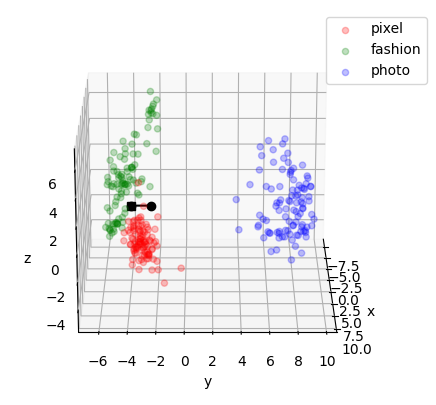

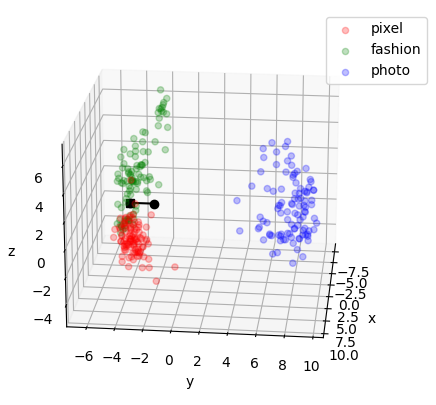

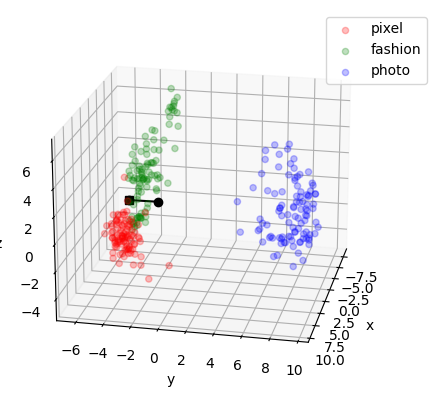

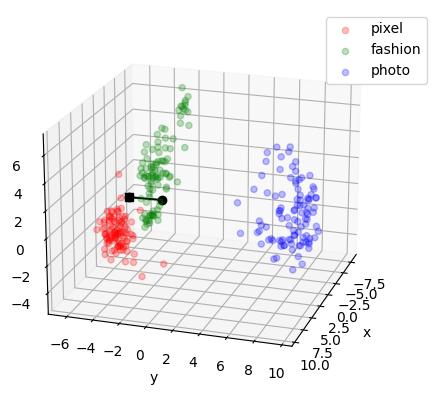

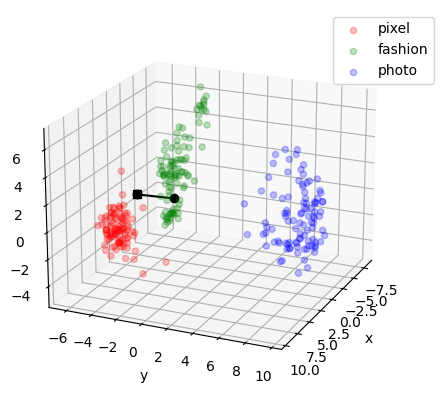

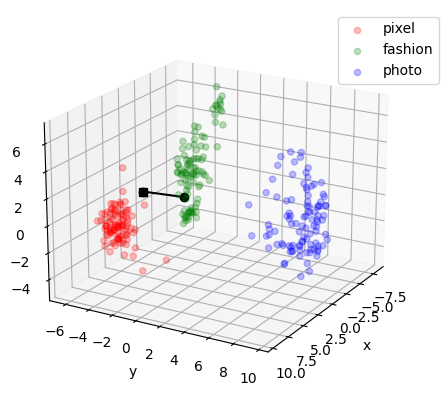

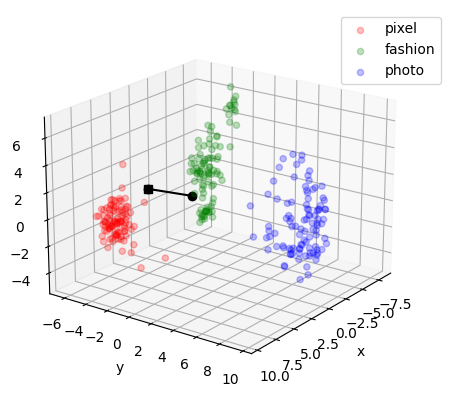

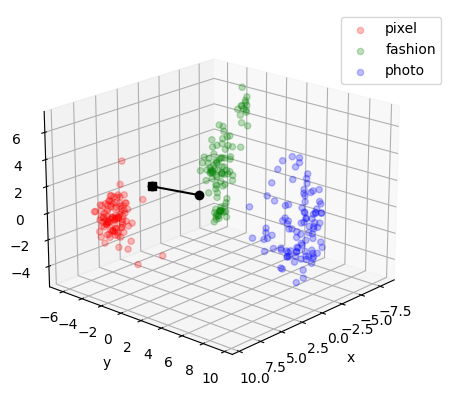

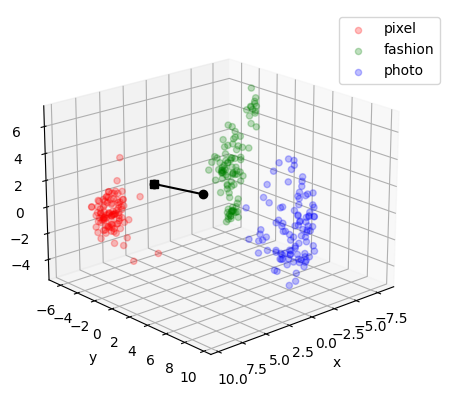

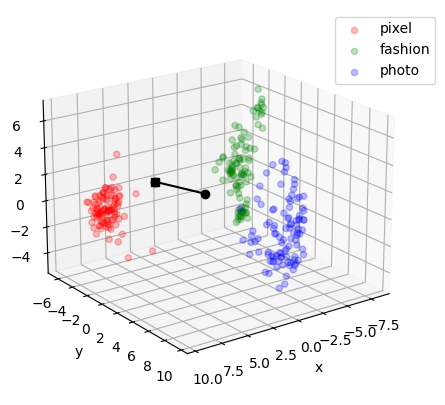

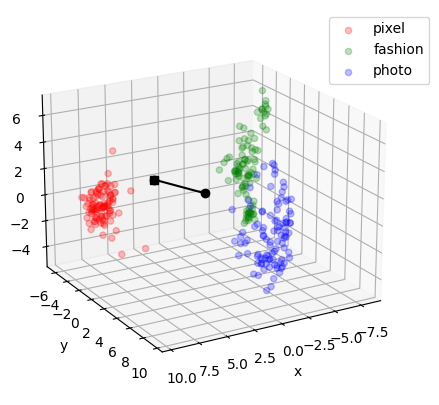

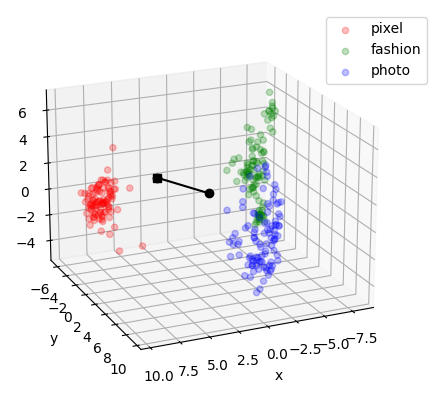

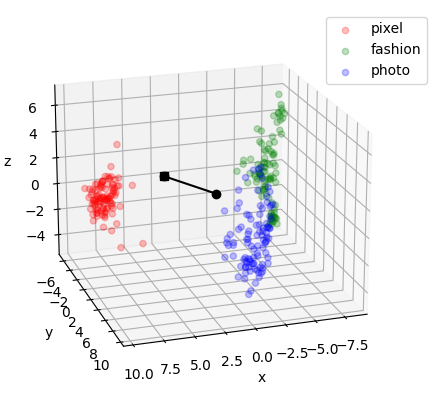

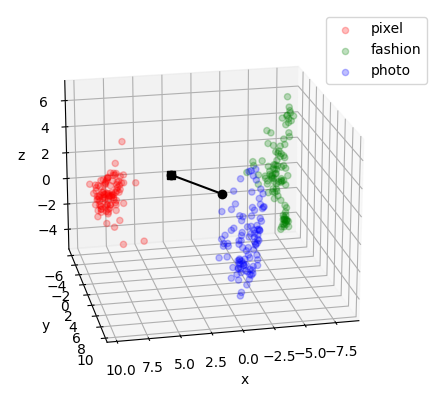

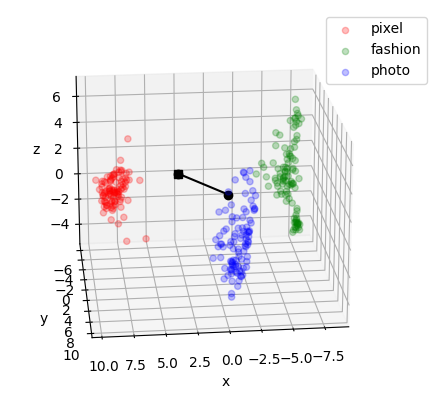

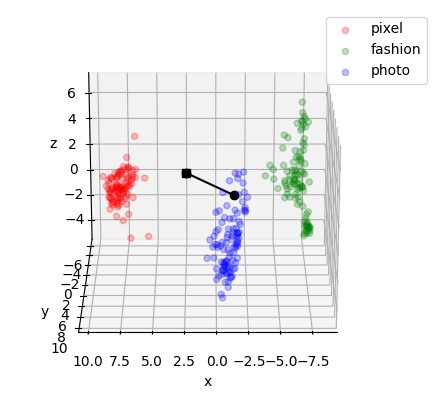

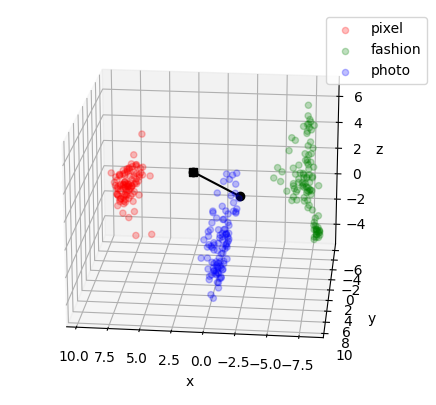

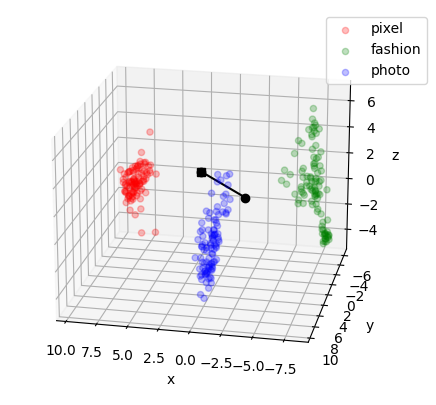

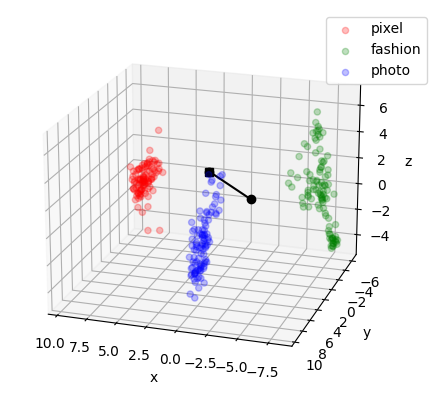

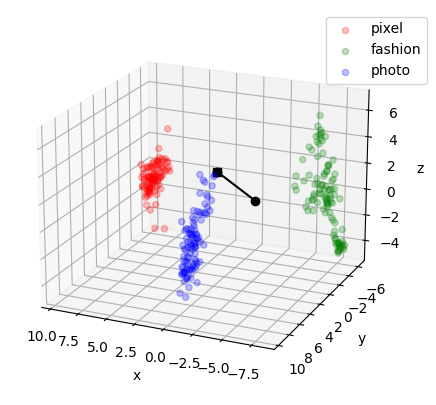

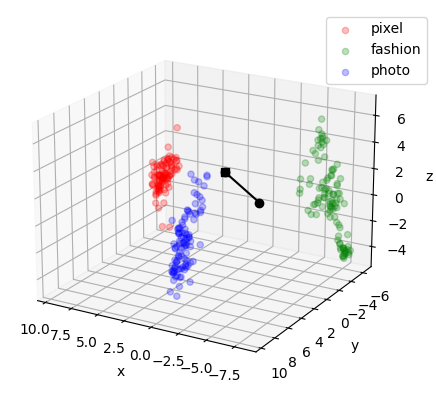

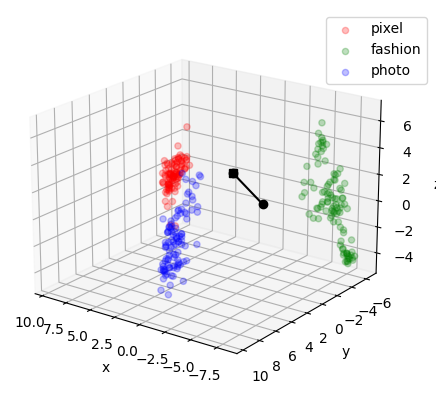

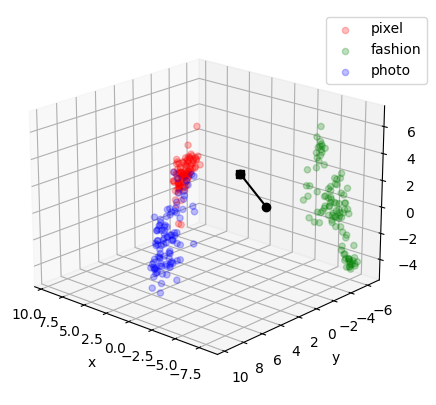

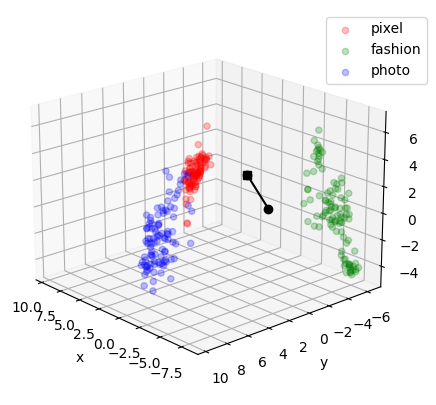

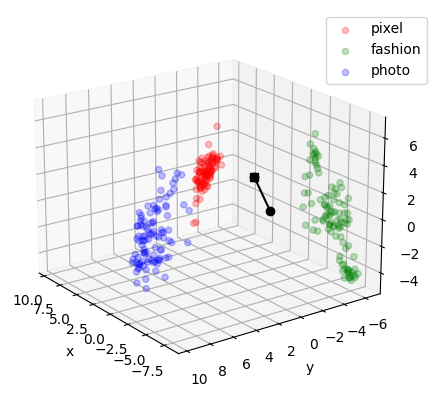

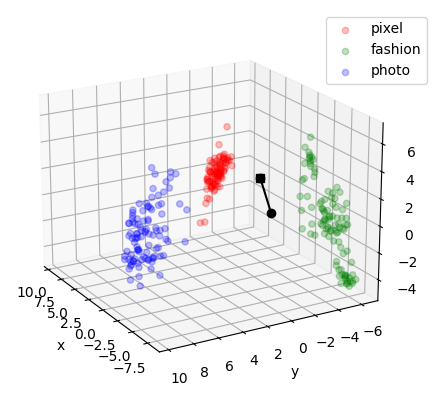

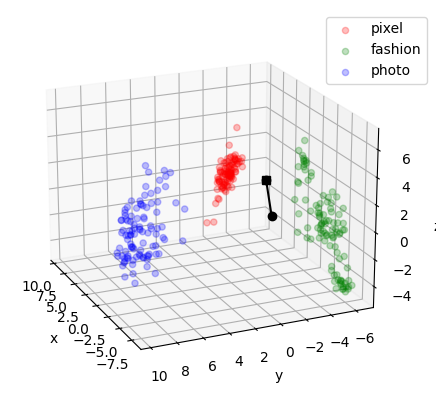

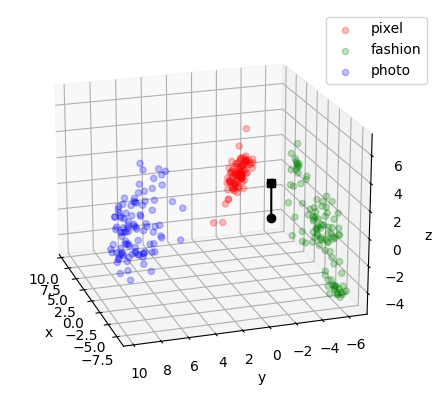

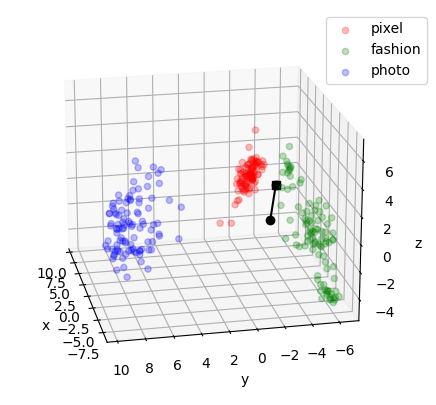

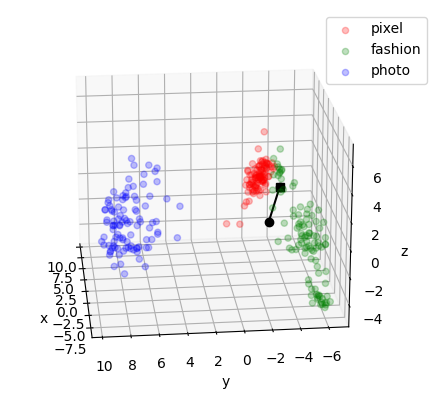

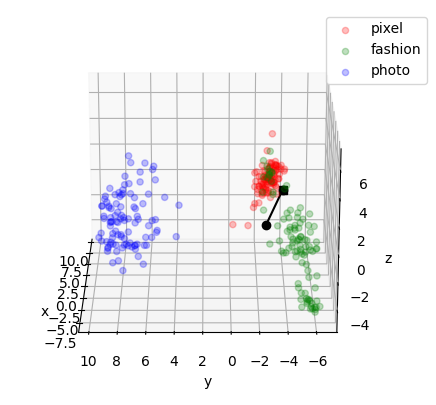

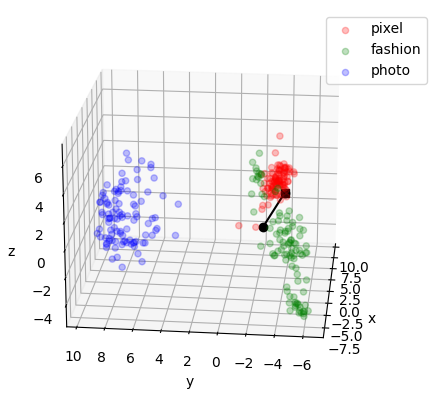

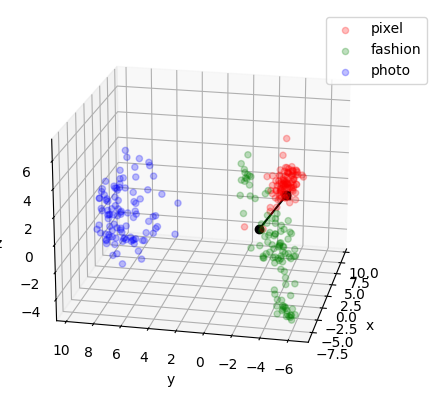

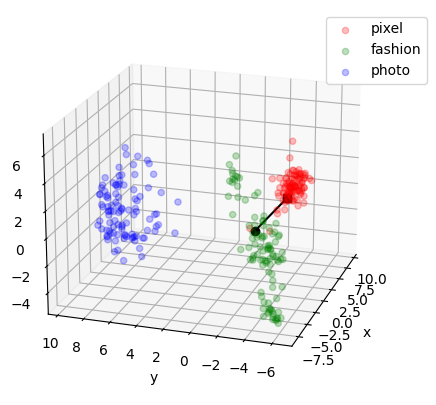

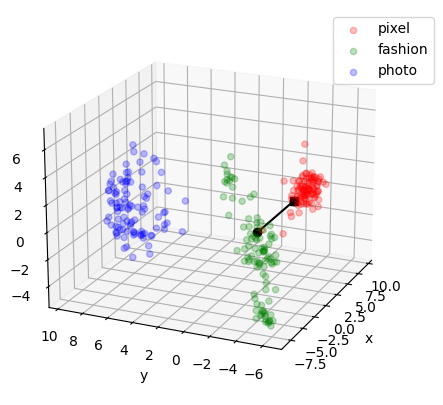

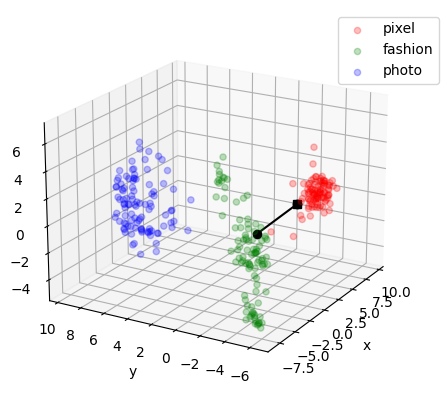

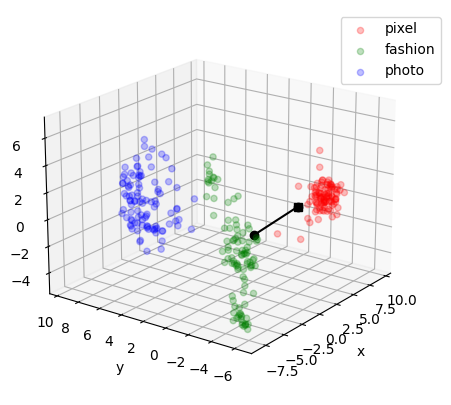

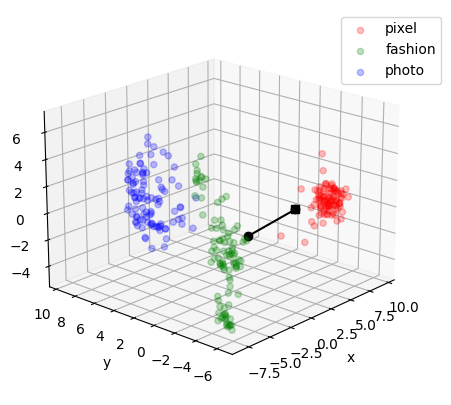

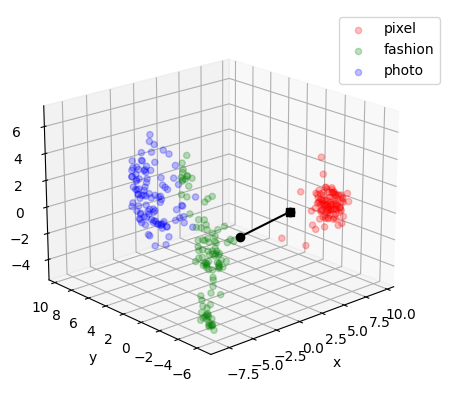

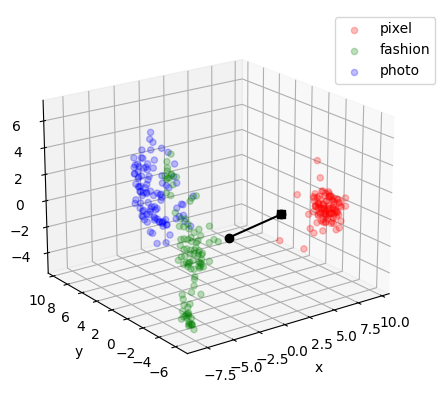

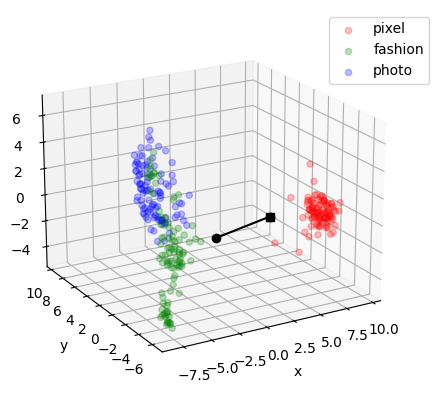

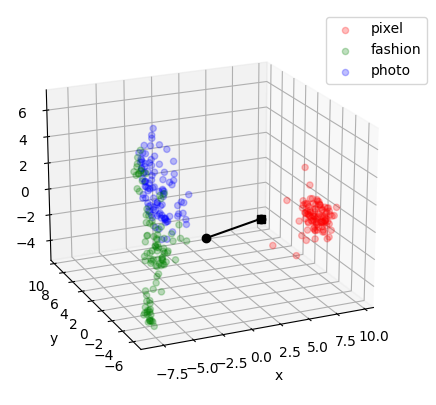

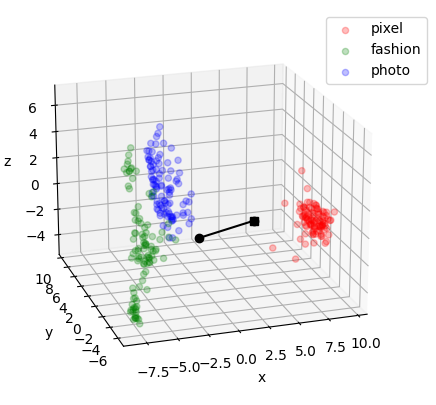

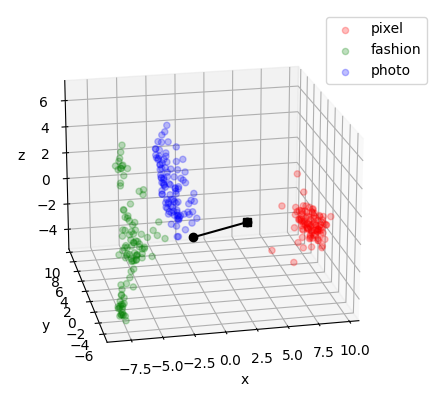

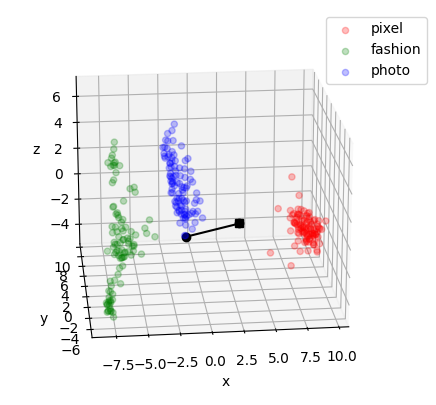

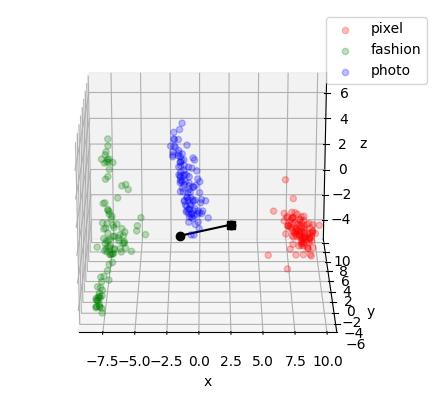

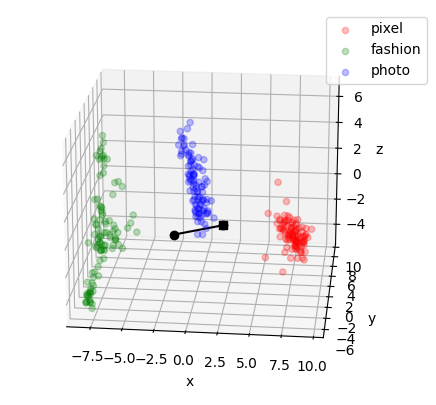

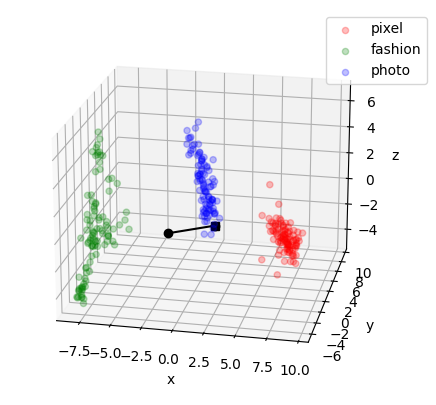

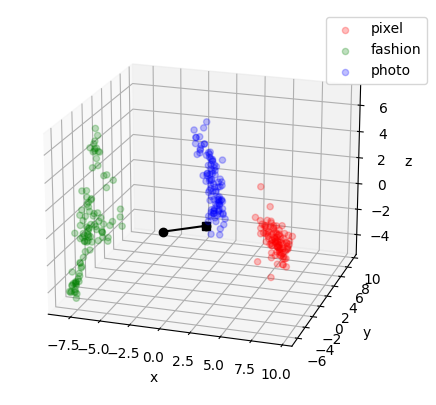

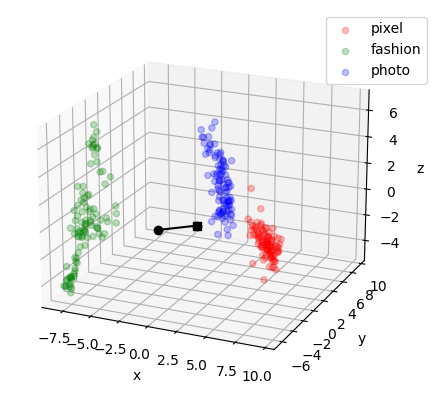

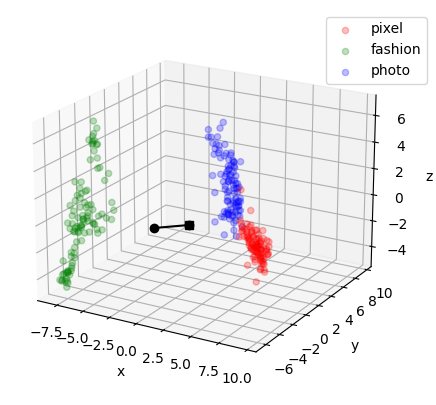

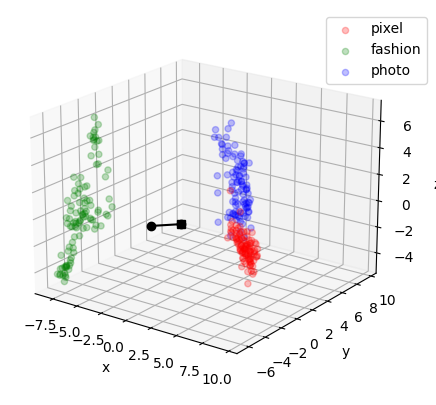

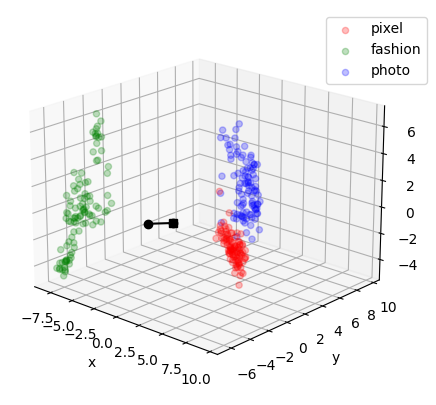

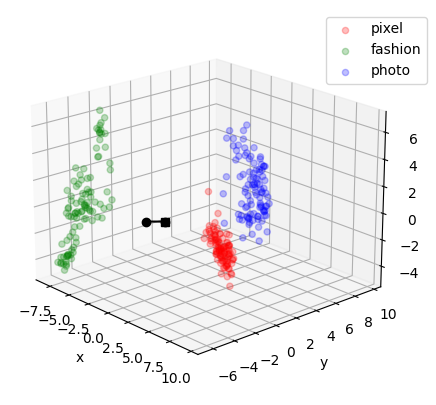

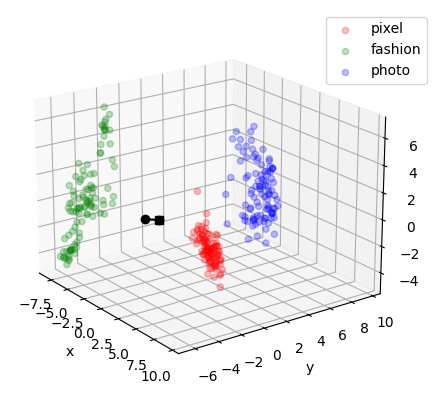

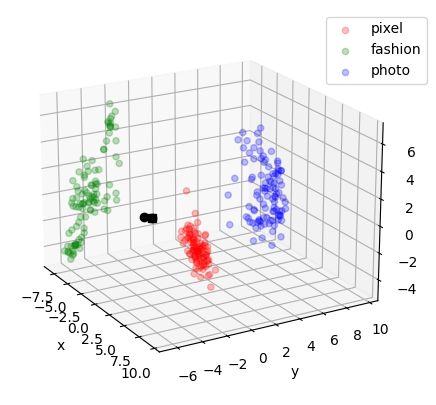

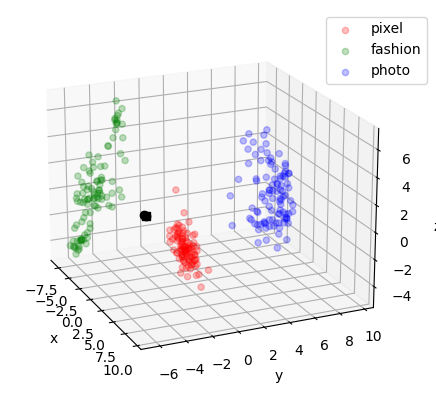

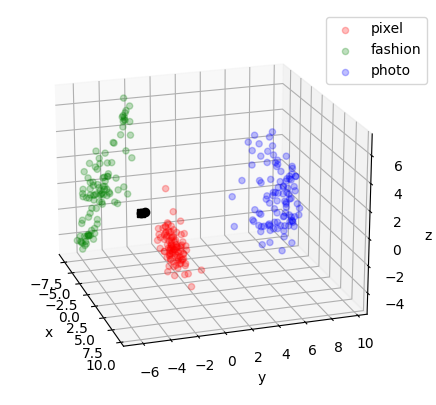

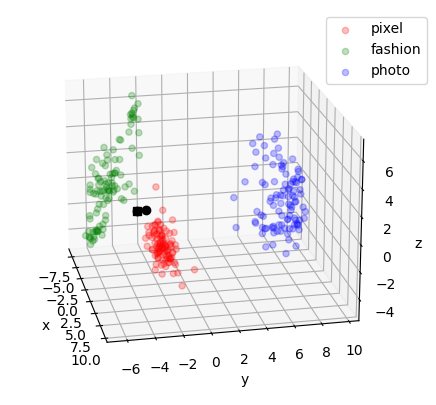

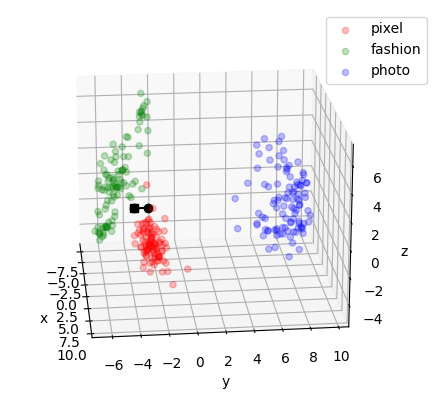

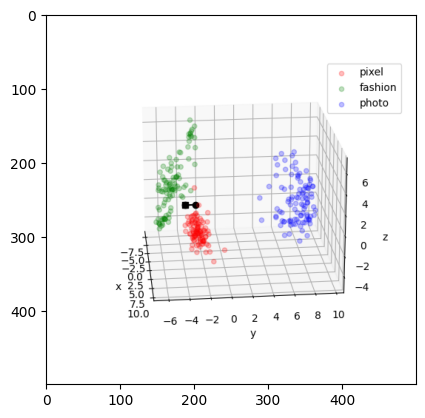

In [75]:
d_sets = {
    "pixel":pixelart_dataset,
    "fashion":clothes_dataset,
    "photo":photo_graph_dataset
}
analyze_transition(model, processor, d_sets, image_o.images[0], image_b[0])

# To be implemented...

In [ ]:
# UMAP
umap_model = umap.UMAP(
    n_neighbors=4, # can play with this
    n_components=2, # projection dimensions
    min_dist=0.25, # can play with this. For lower values, the low-dim projection will have more defined clusters.
    metric="cosine", # Could be "cosine" or "euclidean"
    random_state=42
)

low_dim_mapper = umap_model.fit(embeddings)
low_dim_embeds = low_dim_mapper.embedding_ # these are the low-dim projections.